In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jangedoo/utkface-new")

print("Path to dataset files:", path)

100%|██████████| 331M/331M [00:08<00:00, 40.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/jangedoo/utkface-new/versions/1


In [2]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
folder_path = '/root/.cache/kagglehub/datasets/jangedoo/utkface-new/versions/1/utkface_aligned_cropped/UTKFace'

In [4]:
age = []
gender = []
img_path = []

for file in os.listdir(folder_path):
    age.append(int(file.split('_')[0]))
    gender.append(int(file.split('_')[1]))
    img_path.append(file)


In [5]:
len(age)

23708

In [6]:
df = pd.DataFrame({'age': age, 'gender': gender, 'img': img_path})

In [7]:
df.shape

(23708, 3)

In [8]:
df.head()

age  gender                                    img
0   26       1  26_1_0_20170117174848271.jpg.chip.jpg
1   99       0  99_0_0_20170117195137161.jpg.chip.jpg
2   31       0  31_0_1_20170117130014250.jpg.chip.jpg
3   45       0  45_0_0_20170111181750431.jpg.chip.jpg
4   37       0  37_0_0_20170117183624982.jpg.chip.jpg

In [9]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=0)


In [10]:
train_df['age'] = train_df['age'].astype(float)
train_df['gender'] = train_df['gender'].astype(int)  # binary (0 or 1)

In [11]:
train_df.shape

(18966, 3)

In [12]:
test_df.shape

(4742, 3)

In [13]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

In [14]:
batch_size = 32
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=folder_path,
    x_col='img',
    y_col=['age', 'gender'],  # providing 2 output as we are working on 2 output model
    target_size=(200,200),
    class_mode='raw',  # multi_output because output are more than 1
    batch_size=batch_size,
)

test_generator = train_datagen.flow_from_dataframe(
    test_df,
    directory=folder_path,
    x_col='img',
    y_col=['age', 'gender'],
    target_size=(200, 200),
    class_mode='raw',
    batch_size=batch_size,
)

Found 18966 validated image filenames.
Found 4742 validated image filenames.


In [15]:
# Function to modify generator output structure
def process_generator(generator):

    for batch_x, batch_y in generator:
        yield batch_x, {'age': batch_y[:, 0], 'gender': batch_y[:, 1]}

# Apply the function to generators
train_generator_fixed = process_generator(train_generator)
test_generator_fixed = process_generator(test_generator)

In [16]:
from keras.applications.vgg16 import VGG16
from keras.layers import *
from keras.models import Model

In [17]:
vggnet = VGG16(include_top=False, input_shape=(200, 200, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [18]:
vggnet.trainable=False

output=vggnet.layers[-1].output  # getting only output layer of vggnet

flatten = Flatten()(output)

dense1 = Dense(512, activation='relu')(flatten)
dense2 = Dense(512, activation='relu')(flatten)

dense3 = Dense(512, activation='relu')(dense1)
dense4 = Dense(512, activation='relu')(dense2)

output1 = Dense(1, activation='linear', name='age')(dense3)   # we can also define the name of any output layer
output2 = Dense(1, activation='sigmoid', name='gender')(dense4)

In [19]:
model = Model(inputs=vggnet.input, outputs=[output1, output2]) # getting input of the vggnet input and output we defined

In [20]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 200, 200, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 200, 200, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 200, 200, 64)   │         36,928 │ block1_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_pool               │ (None, 100, 100, 64)   │              0 │ block1_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv1 (Conv2D)     │ (None, 100, 100, 128)  │         73,856 │ block1_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_conv2 (Conv2D)     │ (None, 100, 100, 128)  │        147,584 │ block2_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 50, 50, 128)    │              0 │ block2_conv2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv1 (Conv2D)     │ (None, 50, 50, 256)    │        295,168 │ block2_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv2 (Conv2D)     │ (None, 50, 50, 256)    │        590,080 │ block3_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_conv3 (Conv2D)     │ (None, 50, 50, 256)    │        590,080 │ block3_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block3_pool               │ (None, 25, 25, 256)    │              0 │ block3_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv1 (Conv2D)     │ (None, 25, 25, 512)    │      1,180,160 │ block3_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv2 (Conv2D)     │ (None, 25, 25, 512)    │      2,359,808 │ block4_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_conv3 (Conv2D)     │ (None, 25, 25, 512)    │      2,359,808 │ block4_conv2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block4_pool               │ (None, 12, 12, 512)    │              0 │ block4_conv3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv1 (Conv2D)     │ (None, 12, 12, 512)    │      2,359,808 │ block4_pool[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv2 (Conv2D)     │ (None, 12, 12, 512)    │      2,359,808 │ block5_conv1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block5_conv3 (Conv2D)

 Total params: 34,116,418 (130.14 MB)

 Trainable params: 19,401,730 (74.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

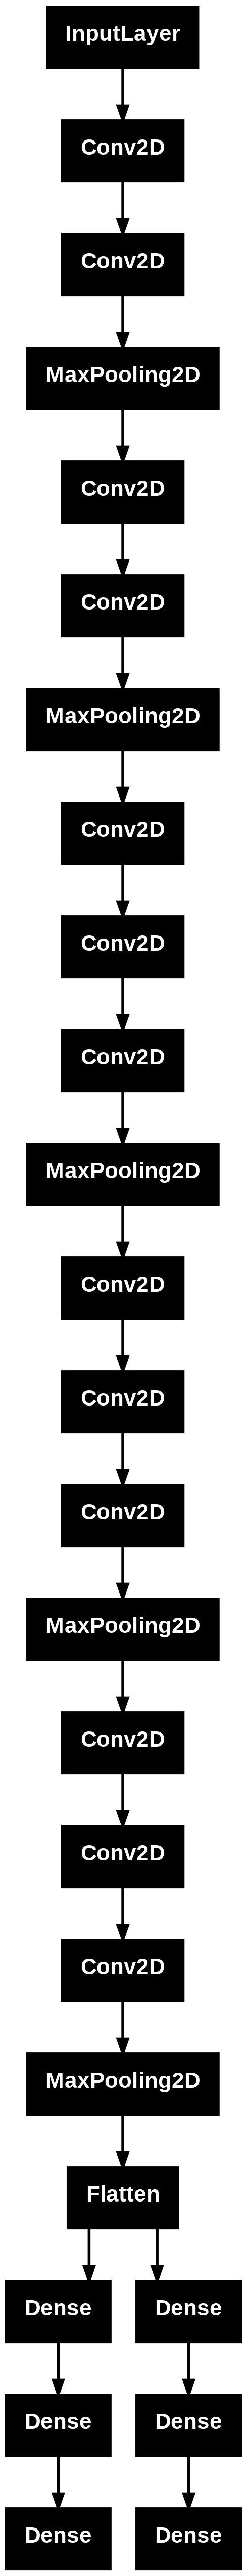

In [21]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [22]:
model.compile(optimizer='adam', loss={'age': 'mae', 'gender': 'binary_crossentropy'}, metrics={'age': 'mae', 'gender': 'accuracy'})

In [23]:
history = model.fit(
    train_generator_fixed,
    steps_per_epoch=5000 // batch_size,
    validation_steps=3000 // batch_size,
    epochs=30,
    validation_data=test_generator_fixed,
)

Epoch 1/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 107s 600ms/step - age_loss: 13.8605 - age_mae: 13.8605 - gender_accuracy: 0.6179 - gender_loss: 0.9608 - loss: 14.8213 - val_age_loss: 14.3013 - val_age_mae: 14.3013 - val_gender_accuracy: 0.6166 - val_gender_loss: 0.6986 - val_loss: 14.9999
Epoch 2/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 94s 606ms/step - age_loss: 11.2172 - age_mae: 11.2172 - gender_accuracy: 0.7549 - gender_loss: 0.4981 - loss: 11.7153 - val_age_loss: 9.9760 - val_age_mae: 9.9763 - val_gender_accuracy: 0.8020 - val_gender_loss: 0.4212 - val_loss: 10.4003
Epoch 3/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 137s 884ms/step - age_loss: 9.9793 - age_mae: 9.9793 - gender_accuracy: 0.7726 - gender_loss: 0.4643 - loss: 10.4436 - val_age_loss: 9.4832 - val_age_mae: 9.4832 - val_gender_accuracy: 0.7463 - val_gender_loss: 0.5111 - val_loss: 9.9944
Epoch 4/30
156/156 ━━━━━━━━━━━━━━━━━━━━ 146s 941ms/step - age_loss: 9.4968 - age_mae: 9.4979 - gender_accuracy: 0.7820 - gender_loss: 0.4541 - loss: 9.9520 - val_

In [24]:
from matplotlib import pyplot as plt


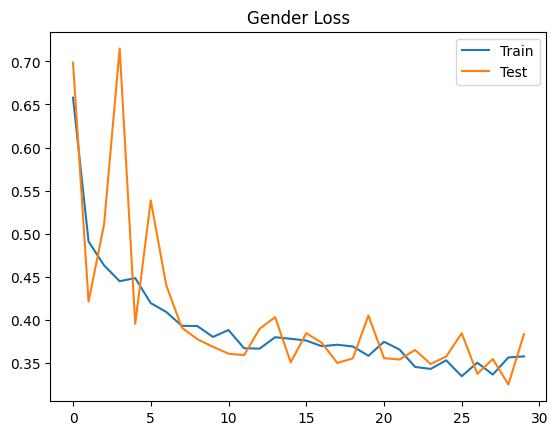

In [29]:

plt.title('Gender Loss')
plt.plot(history.history['gender_loss'], label='Train')
plt.plot(history.history['val_gender_loss'], label='Test')
plt.legend()
plt.show()

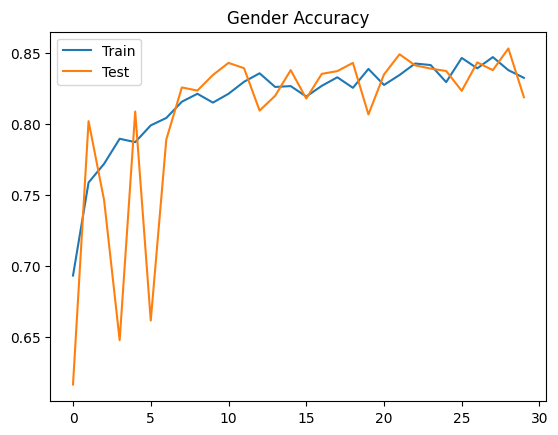

In [27]:
plt.title('Gender Accuracy')

plt.plot(history.history['gender_accuracy'], label='Train')
plt.plot(history.history['val_gender_accuracy'], label='Test')
plt.legend()
plt.show()

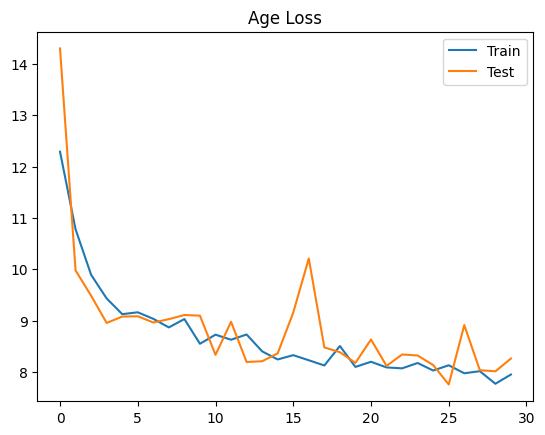

In [28]:
plt.title('Age Loss')

plt.plot(history.history['age_loss'], label='Train')
plt.plot(history.history['val_age_loss'], label='Test')
plt.legend()
plt.show()

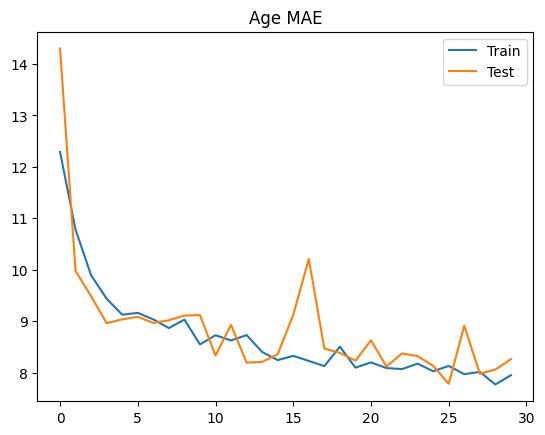

In [30]:
plt.title("Age MAE")

plt.plot(history.history['age_mae'], label='Train')
plt.plot(history.history['val_age_mae'], label='Test')
plt.legend()
plt.show()

In [31]:
import pickle

In [32]:
pickle.dump(model, open('utkFaceModel.pkl', 'wb'))